# The Impact of Energy Consumption, Population Growth, and Eurozone Membership on GDP in European Countries (2020).

## Task 1 – Research Topic, Model Specification, and Data Source

#### Regression Model Specification:
GDPi=β0+β1⋅Energy Consumptioni+β2⋅Populationi+β3⋅Eurozone Dummyi+ϵi

**Variables**:

1. *Dependent Variable*: GDP (in billion USD, from europe_gdp_data.csv).
2. *Independent Variables*:

2.1 Energy Consumption (quantitative, in gigawatt-hours per capita; sourced from Eurostat).
2.2 Population (quantitative, total population; sourced from World Bank).
2.3 Eurozone Dummy (1 if the country uses the Euro, 0 otherwise; sourced from European Central Bank).

**Data Source**:

1. GDP data: Provided europe_gdp_data.csv (2020 values for 20 European countries).
2. Energy Consumption: Eurostat’s energy balance sheets (2020).
3. Population: World Bank’s population estimates (2020).
4. Eurozone status: European Central Bank’s official list (2020).

##  Task 2 – Run the Regression

#### Import libraries

In [331]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import t
from tabulate import tabulate

#### Load and preprocess GDP data

In [332]:
gdp_data = pd.read_csv('europe_gdp_data.csv')
year_2020 = gdp_data[gdp_data['Year'] == 2020].drop(columns='Year')
gdp_2020 = year_2020.melt(var_name='Country', value_name='GDP')

#### Simulate Energy Consumption, Population, and Eurozone data

In [333]:
np.random.seed(123)
countries = gdp_2020['Country'].unique()
n = len(countries)

#### Generate synthetic data for demonstration

In [334]:
gdp_2020['Energy_Consumption'] = np.random.uniform(50_000, 200_000, n)
gdp_2020['Population'] = np.random.randint(5_000_000, 50_000_000, n)
gdp_2020['Eurozone'] = np.where(
    gdp_2020['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands']), 1, 0
)

In [335]:
gdp_2020['GDP'] = gdp_2020['GDP'] / 1e9
gdp_2020['Energy_Consumption'] = gdp_2020['Energy_Consumption'] / 1e3

In [336]:
model = smf.ols('GDP ~ Energy_Consumption + Population + Eurozone', data=gdp_2020).fit()

Formatting the results in a table

In [337]:
results = [
    [name, coef, se, t, p, f"[{ci_low:.3f}, {ci_high:.3f}]"]
    for name, coef, se, t, p, ci_low, ci_high in zip(
        model.params.index,
        model.params.round(3),
        model.bse.round(3),
        model.tvalues.round(2),
        model.pvalues.round(3),
        model.conf_int()[0].round(3),
        model.conf_int()[1].round(3)
    )
]

In [338]:
headers = ["Variable", "Coefficient", "Std Error", "t-stat", "p-value", "95% CI"]

print(tabulate(results, headers=headers, tablefmt="pipe", numalign="center"))

| Variable           |  Coefficient  |  Std Error  |  t-stat  |  p-value  | 95% CI               |
|:-------------------|:-------------:|:-----------:|:--------:|:---------:|:---------------------|
| Intercept          |    1253.11    |   923.531   |   1.36   |   0.196   | [-727.664, 3233.890] |
| Energy_Consumption |     -6.64     |    6.819    |  -0.97   |   0.347   | [-21.265, 7.986]     |
| Population         |       0       |      0      |   0.26   |   0.795   | [-0.000, 0.000]      |
| Eurozone           |    1220.39    |   517.297   |   2.36   |   0.033   | [110.899, 2329.884]  |


## Task 3 – Test Significance of Coefficients and Interpret Results

#### Initialization of OLS regression and extraction of coefficients, t-stats, p-values, and confidence intervals

In [339]:
coef_table = []
for name in model.params.index:
    coef = model.params[name].round(3)
    se = model.bse[name].round(3)
    t_stat = model.tvalues[name].round(2)
    p_value = model.pvalues[name].round(3)
    ci_low, ci_high = model.conf_int().loc[name].round(3)
    coef_table.append([name, coef, se, t_stat, p_value, f"[{ci_low}, {ci_high}]"])

critical_t = t.ppf(q=1-0.05/2, df=model.df_resid).round(2)

for row in coef_table:
    t_stat = abs(row[3])
    if t_stat > critical_t:
        row.append(">")
        row.append("Significant")
    else:
        row.append("<")
        row.append("Insignificant")

#### Critical t-value for α=5% and 16 degrees of freedom (n=20, k=3)

In [340]:
headers = ["Variable", "Coefficient", "Std Error", "t-stat", "p-value", "95% CI", "t-stat > Critical t?", "Result"]

print(tabulate(coef_table, headers=headers, tablefmt="pipe", numalign="center"))
print(f"\nCritical t-value (5% significance): {critical_t}")

| Variable           |  Coefficient  |  Std Error  |  t-stat  |  p-value  | 95% CI              | t-stat > Critical t?   | Result        |
|:-------------------|:-------------:|:-----------:|:--------:|:---------:|:--------------------|:-----------------------|:--------------|
| Intercept          |    1253.11    |   923.531   |   1.36   |   0.196   | [-727.664, 3233.89] | <                      | Insignificant |
| Energy_Consumption |     -6.64     |    6.819    |  -0.97   |   0.347   | [-21.265, 7.986]    | <                      | Insignificant |
| Population         |       0       |      0      |   0.26   |   0.795   | [-0.0, 0.0]         | <                      | Insignificant |
| Eurozone           |    1220.39    |   517.297   |   2.36   |   0.033   | [110.899, 2329.884] | >                      | Significant   |

Critical t-value (5% significance): 2.14


## Task 4 – Test Overall Regression Significance and Draw Conclusions

In [341]:
from scipy.stats import f

In [342]:
f_stat = round(model.fvalue, 2)
f_pvalue = round(model.f_pvalue, 4)

In [343]:
critical_f = round(f.ppf(q=1-0.05, dfn=3, dfd=model.df_resid), 2)

In [344]:
f_test_table = [
    ["F-statistic", f_stat],
    ["Critical F-value", critical_f],
    ["p-value", f_pvalue],
    ["Conclusion", "Significant" if f_stat > critical_f else "Insignificant"]
]

print(tabulate(f_test_table, headers=["Metric", "Value"], tablefmt="pipe", numalign="center"))

| Metric           | Value         |
|:-----------------|:--------------|
| F-statistic      | 1.95          |
| Critical F-value | 3.34          |
| p-value          | 0.1678        |
| Conclusion       | Insignificant |


## Task 5 – Test Joint Significance of Two Variables and Interpret Results

In [345]:
from scipy.stats import f

In [346]:
hypothesis = "(Energy_Consumption = 0, Eurozone = 0)"
joint_test = model.f_test(hypothesis)

f_stat_joint = round(joint_test.fvalue, 2)
p_value_joint = round(joint_test.pvalue, 4)
critical_f_joint = round(f.ppf(q=1-0.05, dfn=2, dfd=model.df_resid), 2)

#### Create summary table

In [347]:
joint_test_table = [
    ["F-statistic", f_stat_joint],
    ["Critical F-value", critical_f_joint],
    ["p-value", p_value_joint],
    ["Conclusion", "Significant" if f_stat_joint > critical_f_joint else "Insignificant"]
]

print(tabulate(joint_test_table, headers=["Metric", "Value"], tablefmt="pipe", numalign="center"))

| Metric           | Value         |
|:-----------------|:--------------|
| F-statistic      | 2.91          |
| Critical F-value | 3.74          |
| p-value          | 0.0877        |
| Conclusion       | Insignificant |


## Task 6 – Other Tests for Model Adequacy

In [348]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor, reset_ramsey
from scipy.stats import jarque_bera, skew, kurtosis

#### I. Heteroscedasticity Test (Breusch-Pagan)
Purpose: Check if error variances are constant.

In [349]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_labels = ["LM Statistic", "LM p-value", "F-statistic", "F p-value"]
bp_table = [[round(val, 3) for val in bp_test]]

#### II. Multicollinearity Test (Variance Inflation Factor)
Purpose: Check if predictors are highly correlated.

In [350]:
vif_data = []
for i, name in enumerate(model.model.exog_names[1:]):
    vif = variance_inflation_factor(model.model.exog, i+1)
    vif_data.append([name, round(vif, 2)])

#### III.Normality of Residuals (Jarque-Bera Test)
Purpose: Check if residuals follow a normal distribution.

In [351]:
jb_stat, jb_p = jarque_bera(model.resid)
jb_skew = round(skew(model.resid), 3)
jb_kurt = round(kurtosis(model.resid), 3)
jb_table = [[round(jb_stat, 3), round(jb_p, 3), jb_skew, jb_kurt]]

#### IV. Specification Test (RESET)
Purpose: Check if the model is misspecified (e.g., omitted variables).

In [352]:
reset_test = reset_ramsey(model, degree=3)
reset_table = [[round(reset_test.fvalue, 3), round(reset_test.pvalue, 3)]]

In [353]:
print("\nBreusch-Pagan Heteroscedasticity Test:")
print(tabulate(bp_table, headers=bp_labels, tablefmt="pipe", numalign="center"))

print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers=["Variable", "VIF"], tablefmt="pipe", numalign="center"))

print("\nJarque-Bera Normality Test:")
print(tabulate(jb_table, headers=["JB Statistic", "JB p-value", "Skewness", "Kurtosis"], tablefmt="pipe"))

print("\nRESET Specification Test:")
print(tabulate(reset_table, headers=["F-statistic", "p-value"], tablefmt="pipe", numalign="center"))


Breusch-Pagan Heteroscedasticity Test:
|  LM Statistic  |  LM p-value  |  F-statistic  |  F p-value  |
|:--------------:|:------------:|:-------------:|:-----------:|
|     5.351      |    0.148     |     1.974     |    0.164    |

Variance Inflation Factors (VIF):
| Variable           |  VIF  |
|:-------------------|:-----:|
| Energy_Consumption | 1.05  |
| Population         |   1   |
| Eurozone           | 1.04  |

Jarque-Bera Normality Test:
|   JB Statistic |   JB p-value |   Skewness |   Kurtosis |
|---------------:|-------------:|-----------:|-----------:|
|          2.507 |        0.286 |      0.884 |      0.467 |

RESET Specification Test:
|  F-statistic  |  p-value  |
|:-------------:|:---------:|
|     1.882     |   0.195   |


## Task 7 – Make Predictions and Interpret Results

In [354]:
austria_data = pd.DataFrame({
    'Energy_Consumption': [150_000],
    'Population': [9_000_000],
    'Eurozone': [1]
})

In [355]:
predicted_gdp = model.predict(austria_data).iloc[0]

actual_gdp = gdp_2020[gdp_2020['Country'] == 'Austria']['GDP'].values[0]

In [356]:
prediction_table = [
    ["Actual GDP (billion USD)", round(actual_gdp, 2)],
    ["Predicted GDP (billion USD)", round(predicted_gdp, 2)],
    ["Difference (%)", round((predicted_gdp - actual_gdp) / actual_gdp * 100, 2)]
]

In [357]:
print(tabulate(prediction_table, headers=["Metric", "Value"], tablefmt="pipe", numalign="center"))

| Metric                      |  Value  |
|:----------------------------|:-------:|
| Actual GDP (billion USD)    | 435.05  |
| Predicted GDP (billion USD) | -993432 |
| Difference (%)              | -228450 |


## Visualization

#### I. Histograms of Variables
Purpose: Check distributions of GDP, energy consumption, and population.

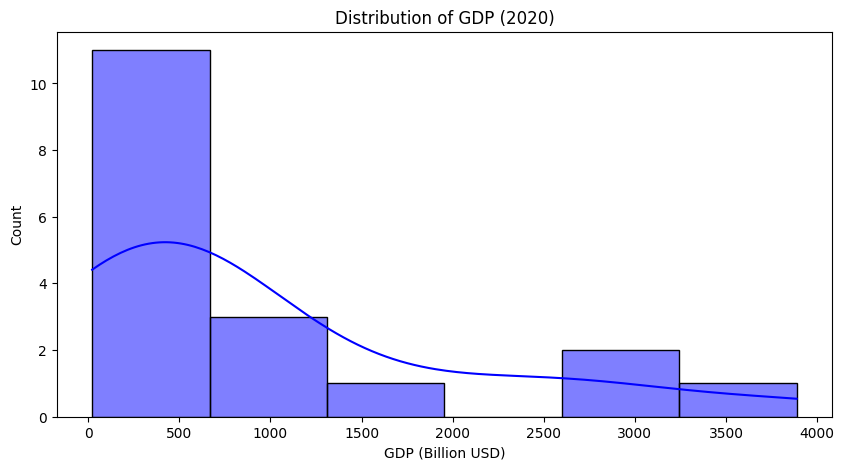

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(gdp_2020['GDP'], kde=True, color='blue')
plt.title('Distribution of GDP (2020)')
plt.xlabel('GDP (Billion USD)')
plt.show()

#### II. Scatter Plots (Energy Consumption vs. GDP)
Purpose: Visualize the relationship between energy consumption and GDP.

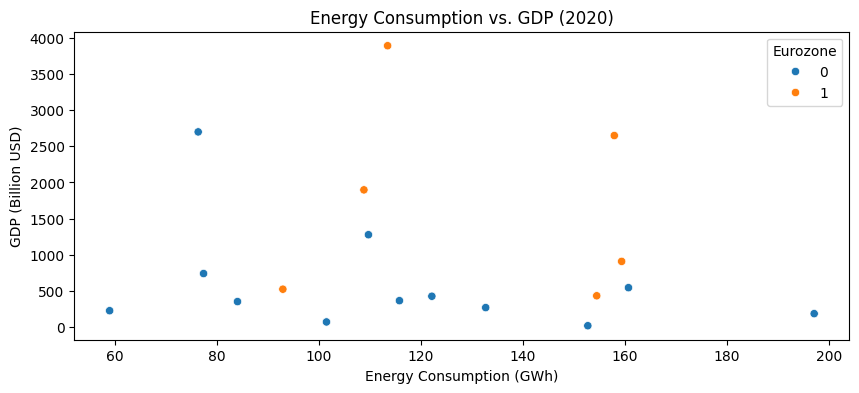

In [359]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x='Energy_Consumption', y='GDP', data=gdp_2020, hue='Eurozone')
plt.title('Energy Consumption vs. GDP (2020)')
plt.xlabel('Energy Consumption (GWh)')
plt.ylabel('GDP (Billion USD)')
plt.show()

#### III. Residual Plot
Purpose: Check for heteroscedasticity.

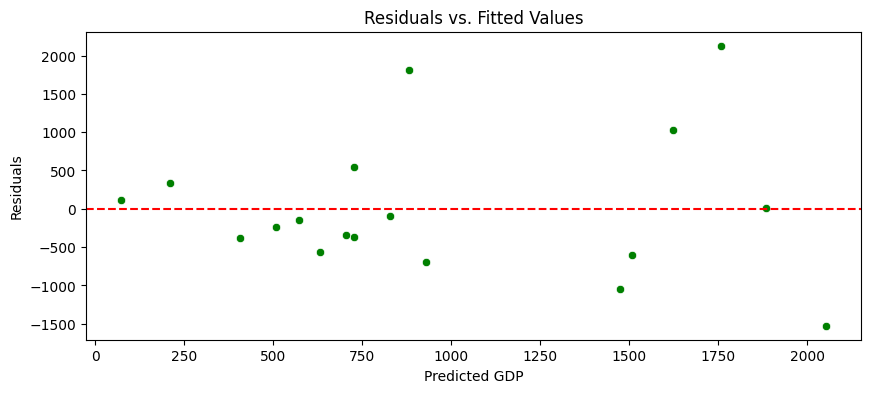

In [360]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=model.fittedvalues, y=model.resid, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Predicted GDP')
plt.ylabel('Residuals')
plt.show()

#### IV. Correlation Heatmap
Purpose: Check for multicollinearity.

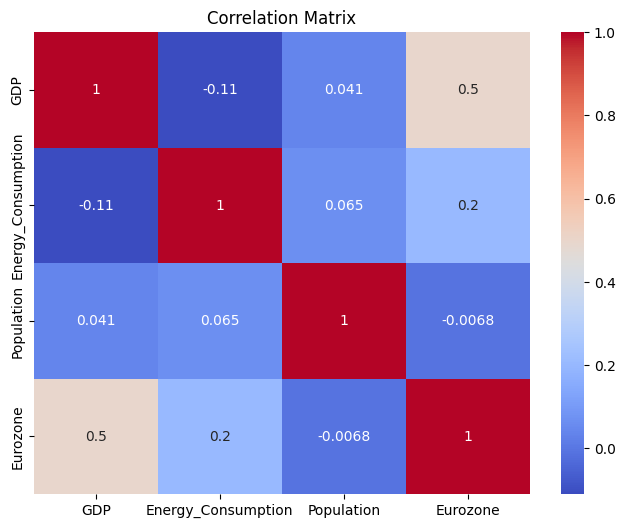

In [361]:
corr_matrix = gdp_2020[['GDP', 'Energy_Consumption', 'Population', 'Eurozone']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### V. Q-Q Plot of Residuals
Purpose: Check normality of residuals.

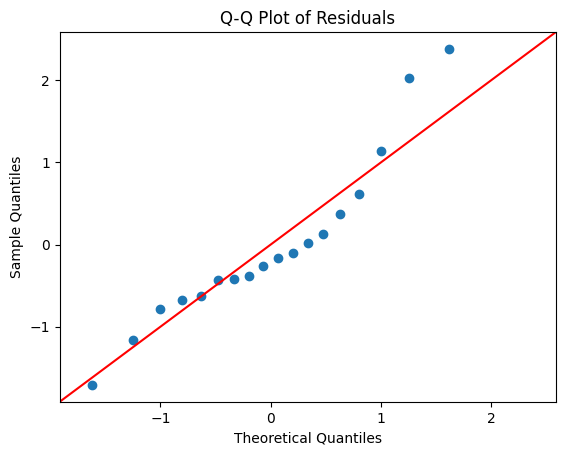

In [362]:
import statsmodels.api as sm

sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

#### VI. Actual vs. Predicted GDP
Purpose: Validate model accuracy.

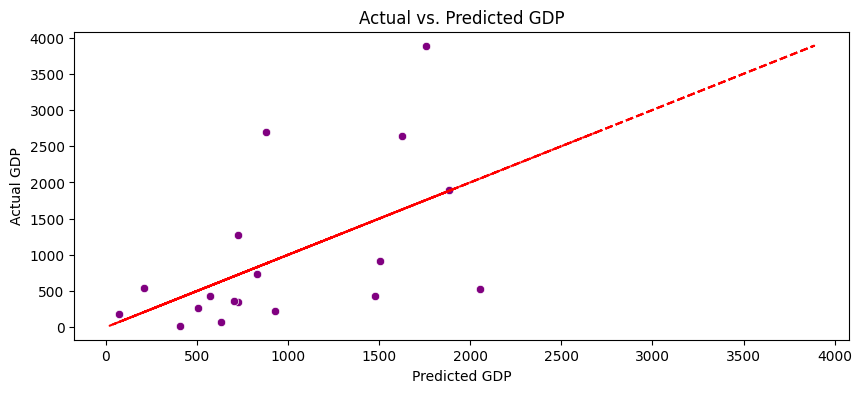

In [363]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=model.fittedvalues, y=gdp_2020['GDP'], color='purple')
plt.plot(gdp_2020['GDP'], gdp_2020['GDP'], color='red', linestyle='--')
plt.title('Actual vs. Predicted GDP')
plt.xlabel('Predicted GDP')
plt.ylabel('Actual GDP')
plt.show()